In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import math
import dask
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

In [2]:
from dask.distributed import Client, LocalCluster
if __name__ == "__main__":
    cluster=LocalCluster(host="tcp://127.0.0.1:2452",dashboard_address="127.0.0.1:2462",n_workers=4)
    client = Client(cluster)

In [3]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list.

        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.

        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))

    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [4]:
def pre_process(U,V):
    try:
        U.longitude
        U.latitude
    except:
        V = V.rename({'lon':'longitude'})
        V = V.rename({'lat':'latitude'})
        U = U.rename({'lon':'longitude'})
        U = U.rename({'lat':'latitude'})
        U.longitude
        U.latitude
    try:
        test = U.uas
    except:
        try:
            test = U.ua
            U = U.rename({'ua':'uas'})
            V = V.rename({'va':'vas'})
        except:
            U = U.rename({'uwnd':'uas'})
            V = V.rename({'vwnd':'vas'})
    try:
        test = U.level
    except:
        try:
            test = U.plev
            U = U.rename({'plev':'level'})
            V = V.rename({'plev':'level'})
        except:
            U = U.rename({'height':'level'})
            V = V.rename({'height':'level'})
    return U,V

In [20]:
two_deg  = xr.open_mfdataset(glob.glob(str("/home/pmarsh/MASTER_final/FRONT/FRONT_FILES/2deg/ERA5_front_6hr_2deg_1996.nc"))).front.sel(time=slice('1996-08-01', '1996-09-30'))
two_deg = two_deg.where(two_deg>0)
two_deg = two_deg/two_deg

In [21]:
native = xr.open_mfdataset(glob.glob(str("/home/pmarsh/MASTER_final/FRONT/FRONT_FILES/native/*ERA5*"))).front.sel(time=slice('1996-08-01', '1996-09-30'))
native = native.where(native>0)
native = native/native

In [22]:
U = xr.open_mfdataset(glob.glob("/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/6hr/native/ua*"))
V = xr.open_mfdataset(glob.glob("/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/6hr/native/va*"))

U,V = pre_process(U,V)
U = U.sel(time=slice('1996-08-01', '1996-09-30')) 
V = V.sel(time=slice('1996-08-01', '1996-09-30'))
U = U.sel(level=950) 
V = V.sel(level=950) 
U = U.sel(latitude = slice(-15,-75))
U = xr.concat([U.sel(longitude = slice(0,30)),U.sel(longitude = slice(320,360))],dim='longitude')
V = V.sel(latitude = slice(-15,-75))
V = xr.concat([V.sel(longitude = slice(0,30)),V.sel(longitude = slice(320,360))],dim='longitude')
V.coords['longitude'] = (V.coords['longitude'] + 180) % 360 - 180
U.coords['longitude'] = (U.coords['longitude'] + 180) % 360 - 180
U = U.sortby(U.longitude).load()
V = V.sortby(U.longitude).load()

ws = np.sqrt(np.square(U.uas) + np.square(V.vas))
Dir=np.mod(180+np.rad2deg(np.arctan2(U.uas, V.vas)),360)

U = U.uas
V = V.vas

In [23]:
pr = xr.open_mfdataset(glob.glob("/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/1hr/native/pr*"))
pr = pr.sel(time=slice('1996-08-01', '1996-09-30'))
zero = pr.where(pr.time.dt.hour == 0).dropna(dim='time',how='all')
six = pr.where(pr.time.dt.hour == 6).dropna(dim='time',how='all')
twelve = pr.where(pr.time.dt.hour == 12).dropna(dim='time',how='all')
eighteen = pr.where(pr.time.dt.hour == 18).dropna(dim='time',how='all')
pr = xr.DataArray(np.concatenate([zero.pr.values, six.pr.values, twelve.pr.values, eighteen.pr.values,]),dims=("time","latitude", "longitude"), coords={"time":np.concatenate([zero.time.values, six.time.values, twelve.time.values, eighteen.time.values]),"longitude":zero.longitude.values ,"latitude": zero.latitude.values})
pr = pr.sel(latitude = slice(-15,-75))
pr = xr.concat([pr.sel(longitude = slice(0,30)),pr.sel(longitude = slice(320,360))],dim='longitude')
pr.coords['longitude'] = (pr.coords['longitude'] + 180) % 360 - 180
pr = pr.sortby(U.longitude).load()
pr = pr.sortby(pr.time)
pr = pr.where(pr>0.0001)

In [24]:
x = native.where(native<0)[0].fillna(0).load()
x[40:-60 , 40:-80] = 1

In [25]:
hex_list = ["FFFFFF","44c3ee","54d812","eb771e","bb11a7","050425"]
cmap=get_continuous_cmap(hex_list)

In [26]:
i = 72
skip=(slice(None,None,4),slice(None,None,4))

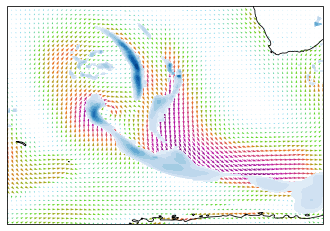

In [27]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m', linewidth=0.8)
ax.quiver(U.longitude.values[::4], U.latitude.values[::4], U.values[i][skip], V.values[i][skip],ws.values[i][skip], cmap = cmap,transform = ccrs.PlateCarree())
p = ax.contourf(pr.longitude.values,pr.latitude.values,pr.values[i],cmap = 'Blues',transform = ccrs.PlateCarree(), levels = 10 , vmin = 0 , vmax = 0.001,alpha = 1)

<ipython-input-28-3ef9c84205ff>:1: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(p,orientation = 'horizontal',label = 'mm/hour')


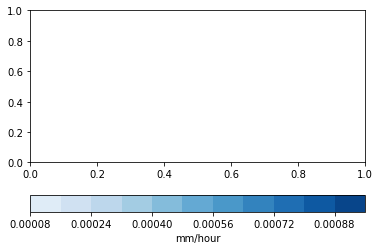

In [28]:
plt.colorbar(p,orientation = 'horizontal',label = 'mm/hour')
plt.savefig('/home/pmarsh/MASTERS/FRONT/FRONT_OUT/cbar_pr_demostration.pdf')

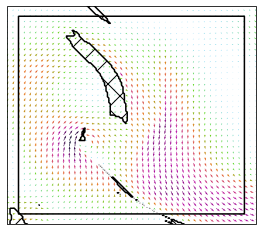

In [29]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.rcParams['hatch.linewidth']=1
plt.rcParams['hatch.color']='black'
ax.coastlines('50m', linewidth=0.8)
w = ax.quiver(U.longitude.values[::4], U.latitude.values[::4], U.values[i][skip], V.values[i][skip],ws.values[i][skip], cmap = cmap,transform = ccrs.PlateCarree(),zorder=0)
ax.contour(U.longitude,U.latitude,native[i].fillna(0).values,colors='black',levels = [0.99,1.01], transform = ccrs.PlateCarree(),alpha=1,zorder=2)
ax.contourf(U.longitude,U.latitude,native[i].values,levels = [0.99,1.01], hatches=["x"], transform = ccrs.PlateCarree(),alpha=0,zorder=3)
ax.contour(x.longitude,x.latitude,x.values,levels = [0.99,1.01],alpha = 1, cmap = 'Greys_r' , transform = ccrs.PlateCarree())


<ipython-input-30-57fc8de57fd3>:1: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(w, orientation = 'horizontal',label = 'm/s')


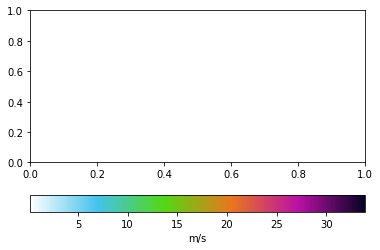

In [30]:
plt.colorbar(w, orientation = 'horizontal',label = 'm/s')
plt.savefig('/home/pmarsh/MASTERS/FRONT/FRONT_OUT/cbar_wind_demostration.pdf')

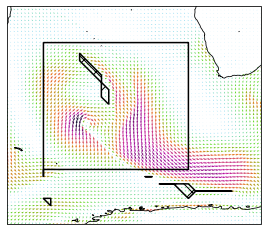

In [32]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.rcParams['hatch.linewidth']=1
plt.rcParams['hatch.color']='black'
ax.coastlines('50m', linewidth=0.8)
ax.quiver(U.longitude.values[::4], U.latitude.values[::4], U.values[i][skip], V.values[i][skip],ws.values[i][skip], cmap = cmap,transform = ccrs.PlateCarree(),zorder=0)
ax.contour(two_deg.longitude,two_deg.latitude,two_deg[i].fillna(0).values,colors='black',levels = [0.99,1.01], transform = ccrs.PlateCarree(),alpha=1,zorder=2)
ax.contourf(two_deg.longitude,two_deg.latitude,two_deg[i].values,levels = [0.99,1.01], hatches=["x"], transform = ccrs.PlateCarree(),alpha=0,zorder=3)
ax.contour(x.longitude,x.latitude,x.values,levels = [0.99,1.01],alpha = 1, cmap = 'Greys_r' , transform = ccrs.PlateCarree())
ax.set_extent([-40, 30, -15, -75], ccrs.PlateCarree())

<ipython-input-33-9b62ba072588>:20: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  plt.gca().outline_patch.set_visible(False)
<ipython-input-33-9b62ba072588>:29: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  plt.gca().outline_patch.set_visible(False)
<ipython-input-33-9b62ba072588>:38: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  plt.gca().outline_patch.set_visible(False)


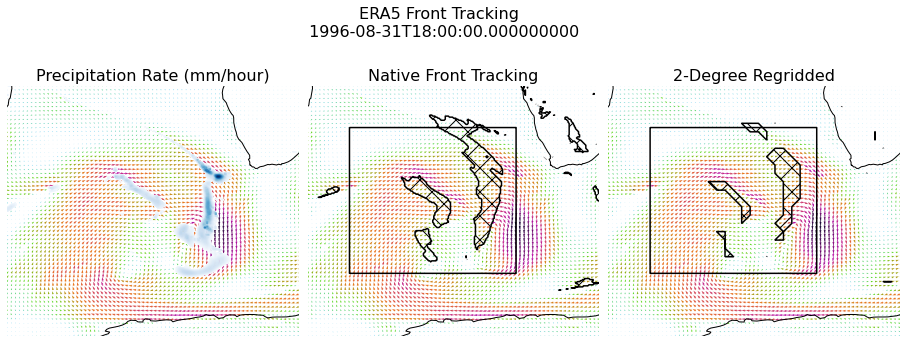

In [33]:
plt.rcParams['hatch.linewidth']=1
plt.rcParams['hatch.color']='black'

#for i in range(len(native.time.values)):
for i in [123]:
    fig = plt.figure(figsize=(16, 9))
    plt.gca().set_visible(False)
    gs = gridspec.GridSpec(nrows=9,
                           ncols=9,
                           figure=fig,
                           width_ratios= [1, 1, 1, 1, 1, 1, 1, 1, 1],
                           height_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1],
                           wspace=0.1,
                           hspace=0.1)
    ax1 = fig.add_subplot(gs[1:8,0:3], projection=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.quiver(U.longitude.values[::4], U.latitude.values[::4], U.values[i][skip], V.values[i][skip],ws.values[i][skip], cmap = cmap,transform = ccrs.PlateCarree())
    ax1.contourf(pr.longitude.values,pr.latitude.values,pr.values[i],cmap = 'Blues',transform = ccrs.PlateCarree(), levels = 1000 , alpha = 0.3)
    ax1.set_extent([-40, 30, -15, -75], ccrs.PlateCarree())
    plt.gca().outline_patch.set_visible(False)
    plt.title('Precipitation Rate (mm/hour)', fontsize=16, ha='center')
    ax2 = fig.add_subplot(gs[1:8,3:6], projection=ccrs.PlateCarree())
    ax2.coastlines()
    ax2.quiver(U.longitude.values[::4], U.latitude.values[::4], U.values[i][skip], V.values[i][skip],ws.values[i][skip], cmap = cmap,transform = ccrs.PlateCarree(),zorder=0)
    ax2.contour(U.longitude,U.latitude,native[i].fillna(0).values,colors='black',levels = [0.99,1.01], transform = ccrs.PlateCarree(),alpha=1,zorder=2)
    ax2.contourf(U.longitude,U.latitude,native[i].values,levels = [0.99,1.01], hatches=["x"], transform = ccrs.PlateCarree(),alpha=0,zorder=3)
    ax2.contour(x.longitude,x.latitude,x.values,levels = [0.99,1.01],alpha = 1, cmap = 'Greys_r' , transform = ccrs.PlateCarree())
    ax2.set_extent([-40, 30, -15, -75], ccrs.PlateCarree())
    plt.gca().outline_patch.set_visible(False)
    plt.title('Native Front Tracking', fontsize=16, ha='center')
    ax3 = fig.add_subplot(gs[1:8,6:9], projection=ccrs.PlateCarree())
    ax3.coastlines()
    ax3.quiver(U.longitude.values[::4], U.latitude.values[::4], U.values[i][skip], V.values[i][skip],ws.values[i][skip], cmap = cmap,transform = ccrs.PlateCarree(),zorder=0)
    ax3.contour(two_deg.longitude,two_deg.latitude,two_deg[i].fillna(0).values,colors='black',levels = [0.99,1.01], transform = ccrs.PlateCarree(),alpha=1,zorder=2)
    ax3.contourf(two_deg.longitude,two_deg.latitude,two_deg[i].values,levels = [0.99,1.01], hatches=["x"], transform = ccrs.PlateCarree(),alpha=0,zorder=3)
    ax3.contour(x.longitude,x.latitude,x.values,levels = [0.99,1.01],alpha = 1, cmap = 'Greys_r' , transform = ccrs.PlateCarree())
    ax3.set_extent([-40, 30, -15, -75], ccrs.PlateCarree())
    plt.gca().outline_patch.set_visible(False)
    plt.title('2-Degree Regridded', fontsize=16, ha='center')
    plt.text(-80, -3,'ERA5 Front Tracking \n '+str(pr.time[i].values), fontsize=16, ha='center')
    plt.savefig('/home/pmarsh/MASTERS/FRONT/FRONT_OUT/Demonstration/ERA5/'+str(i)+'.png')
    #plt.close()
    plt.show()

In [34]:
#cat `ls -v *.png` | ffmpeg -framerate 6 -f image2pipe -i - output.mp4

In [35]:
client.close()